In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(0) # Set for testing purposes, please do not change!

In [2]:
# Display Images
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
# Generator
class Generator(nn.Module):
  def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
    # z_dim = noise vector
    # im_chan = number of channels in input image
    # hidden_dim = hidden image dimentions
    super(Generator, self).__init__()
    self.z_dim = z_dim
    self.gen = nn.Sequential(
        self.make_gen_block(z_dim, hidden_dim * 4),
        self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
        self.make_gen_block(hidden_dim * 2, hidden_dim),
        self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),

    )

  def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
          nn.BatchNorm2d(output_channels),
          nn.ReLU(inplace=True)
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
          nn.Tanh()
      )
  def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

  def forward(self, noise):
    x = self.unsqueeze_noise(noise)
    return self.gen(x)


  def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)


In [4]:
# Discriminator
class Discriminator(nn.Module):
  def __init__(self, im_chan=1, hidden_dim=64):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        self.make_disc_block(im_chan, hidden_dim),
        self.make_disc_block(hidden_dim, hidden_dim * 2),
        self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
    )


  def make_disc_block(self,input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
    if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
    else:
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )
  def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [5]:
# Noise
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [6]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5
beta_2 = 0.999
device = 'cpu'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [7]:
# Init all Methods from above
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [8]:
# Before you train your GAN, you will need to create functions to calculate the discriminator's loss and the generator's loss.
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
  # This will take generator, descriminator, loss function, number o ral imgaes to be generated , number of images, noise vector and device

  # Create noise vectors and generate fake images
  noise = get_noise(num_images, z_dim, device=device)
  fake_images = gen(noise).detach()

  # Discriminator on Fake Images
  fake_preds = disc(fake_images)
  fake_labels = torch.zeros_like(fake_preds) #  Ground truth for real images is 0
  fake_loss = criterion(fake_preds, fake_labels)

  # Discriminator on Real Images
  real_preds = disc(real)
  real_labels = torch.ones_like(real_preds)  # Ground truth for real images is 1
  real_loss = criterion(real_preds, real_labels)

  # combine both losses
  disc_loss = (real_loss + fake_loss) / 2

  return disc_loss


def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
  # This will take generator, descriminator, loss function, number o ral imgaes to be generated , number of images, noise vector and device

  # Create noise vectors and generate fake images
  noise = get_noise(num_images, z_dim, device=device)
  fake_images = gen(noise)

  # Get discriminator’s predictions on the fake images
  fake_preds = disc(fake_images)

  # Calculate the generator’s loss
  real_labels = torch.ones_like(fake_preds)  # Generator wants discriminator to think fake is real
  gen_loss = criterion(fake_preds, real_labels)

  return gen_loss

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 2.2669427052736277, discriminator loss: 0.24101576393842697


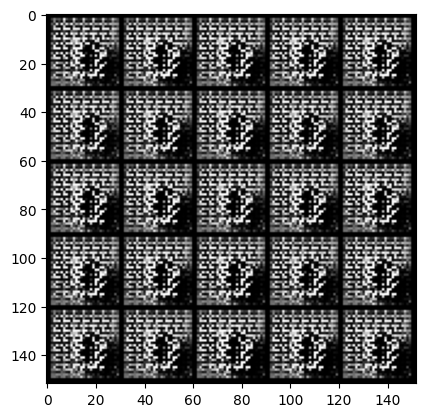

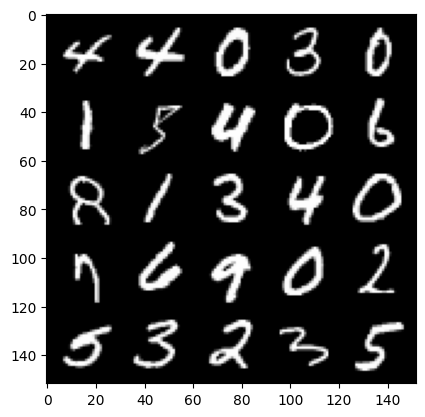

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: 3.8493790678977957, discriminator loss: 0.03827513026352971


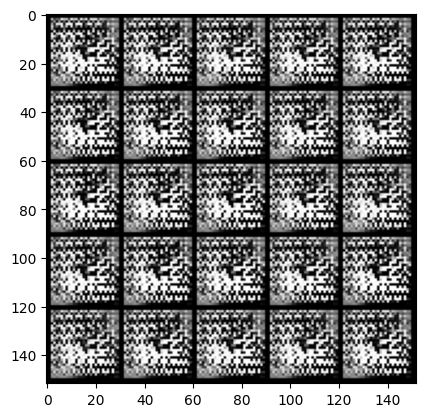

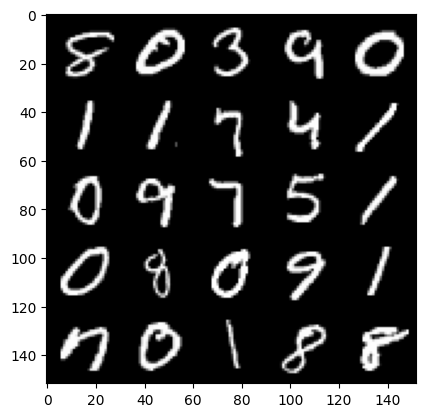

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Generator loss: 4.377321725368501, discriminator loss: 0.02980845122225584


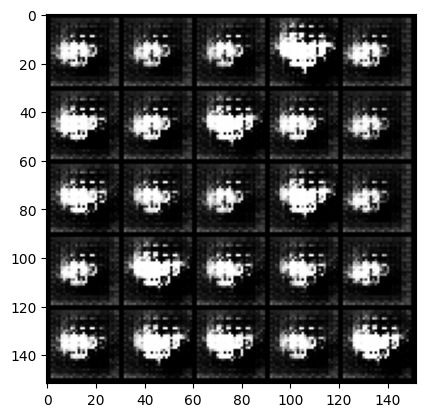

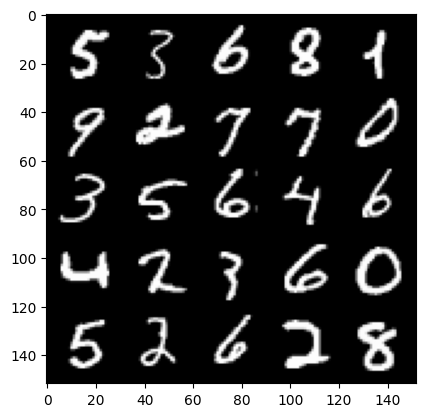

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Generator loss: 4.856496764659883, discriminator loss: 0.022152981024235498


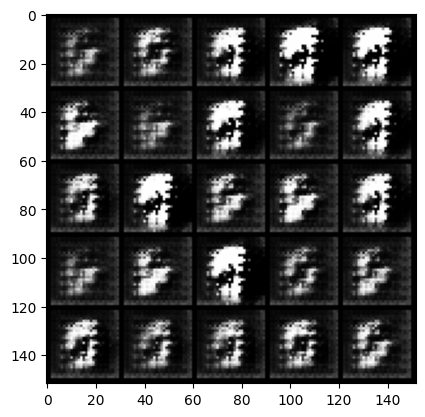

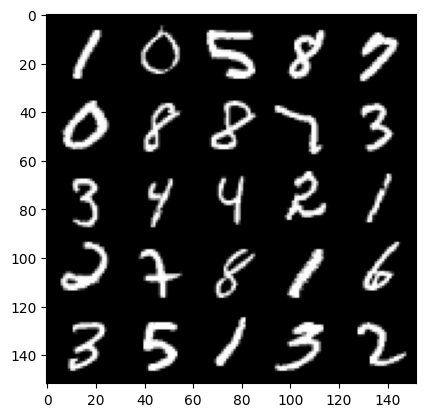

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5, step 2500: Generator loss: 4.079501264095309, discriminator loss: 0.05965815372578801


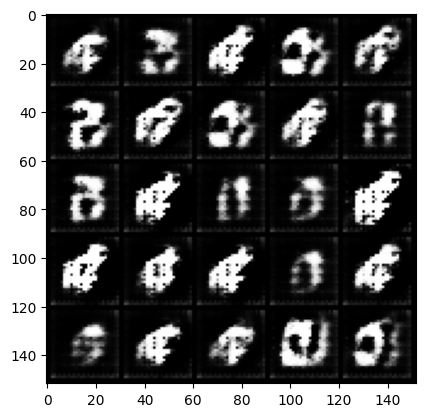

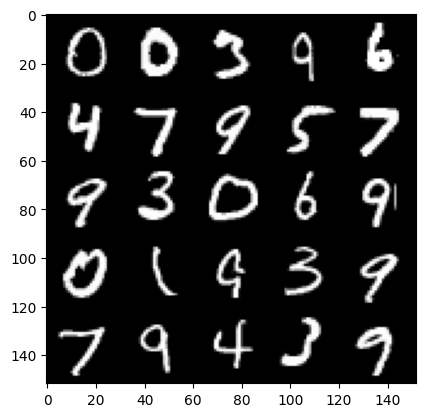

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6, step 3000: Generator loss: 3.480473668575286, discriminator loss: 0.09423744735121725


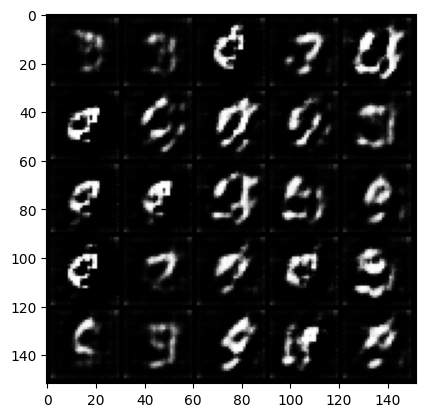

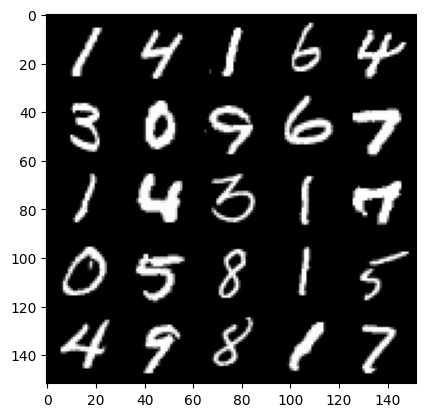

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7, step 3500: Generator loss: 3.190940383911138, discriminator loss: 0.13140787021070718


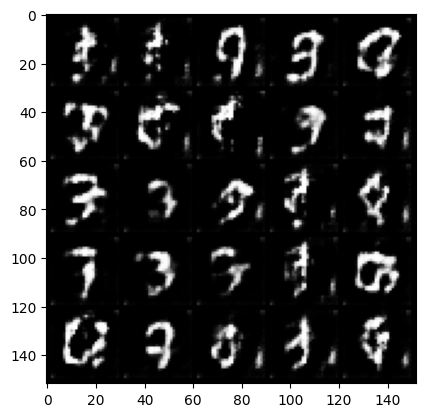

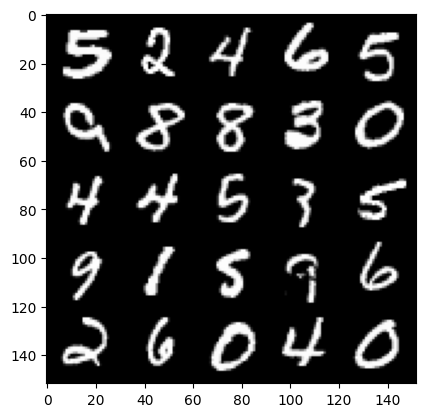

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8, step 4000: Generator loss: 2.7850166237354292, discriminator loss: 0.15389915412664426


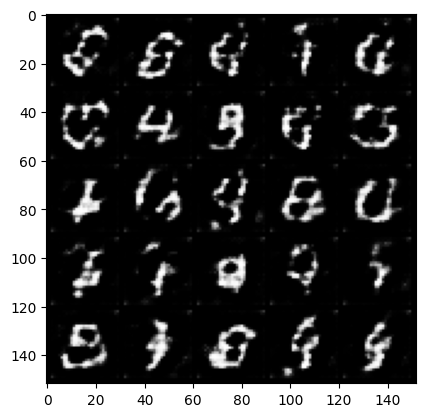

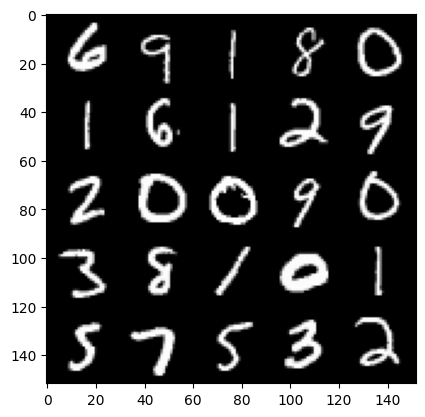

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9, step 4500: Generator loss: 2.78769348931313, discriminator loss: 0.2074101559817793


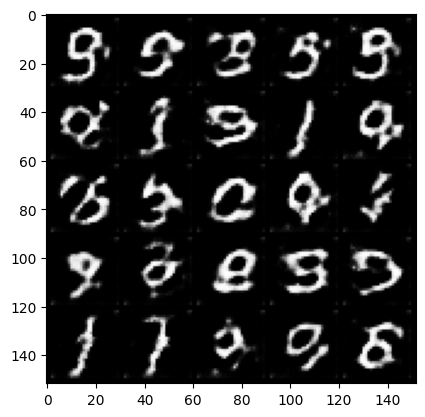

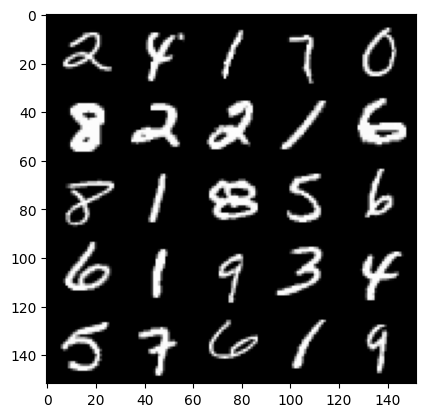

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10, step 5000: Generator loss: 2.231572076678277, discriminator loss: 0.2632985665053128


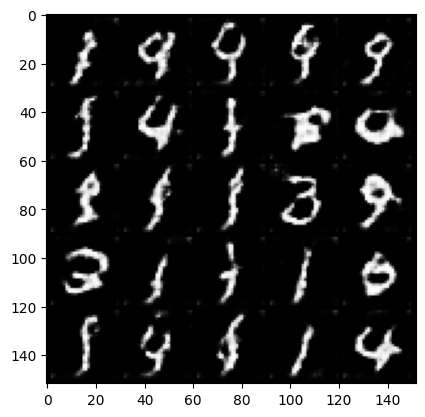

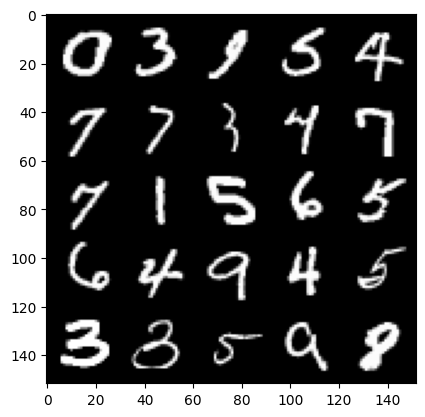

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11, step 5500: Generator loss: 2.097013556718826, discriminator loss: 0.3345159624218941


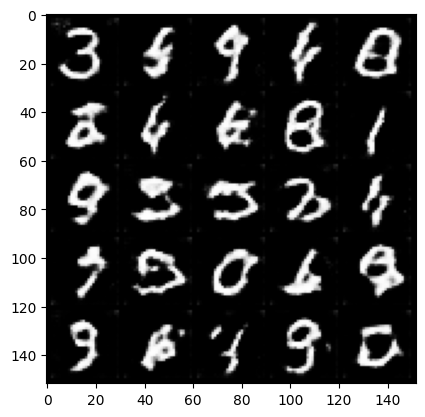

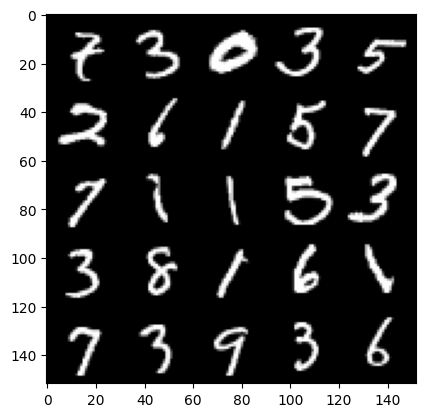

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12, step 6000: Generator loss: 1.9321208326816548, discriminator loss: 0.36670622564852234


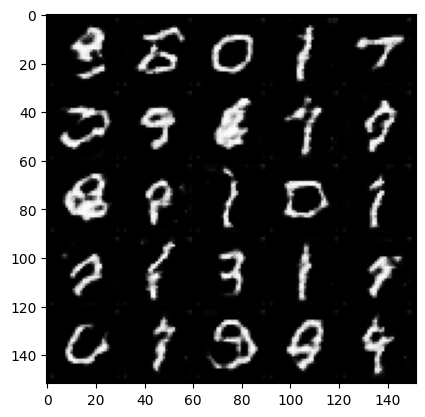

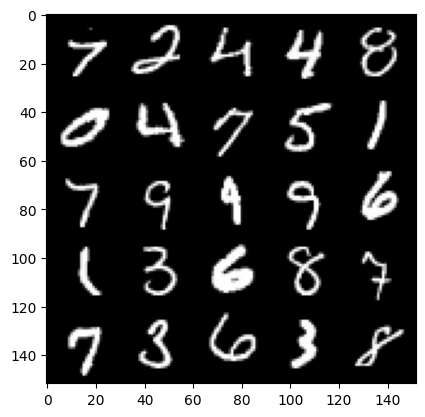

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13, step 6500: Generator loss: 1.7452963148355491, discriminator loss: 0.3986939475536345


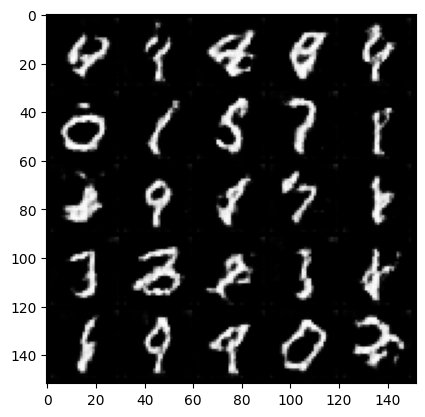

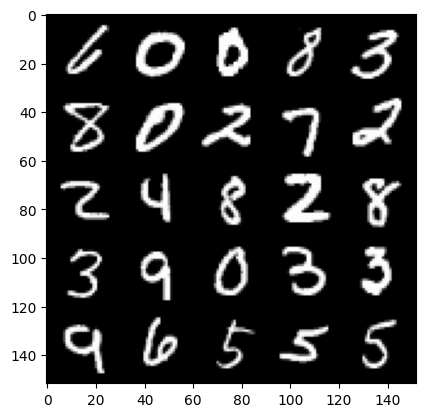

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14, step 7000: Generator loss: 1.6590687773227697, discriminator loss: 0.4232051975131034


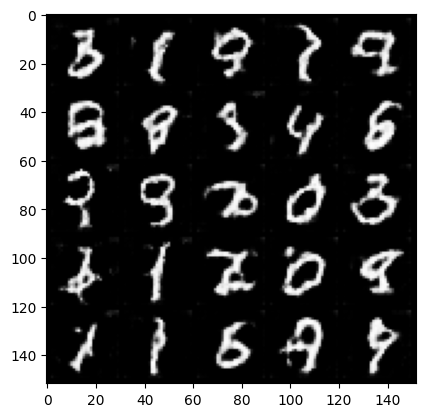

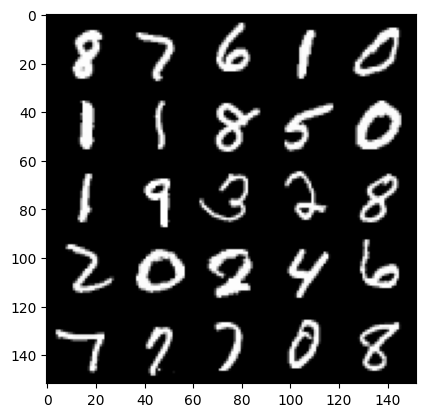

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15, step 7500: Generator loss: 1.6046123209595664, discriminator loss: 0.4315851736366746


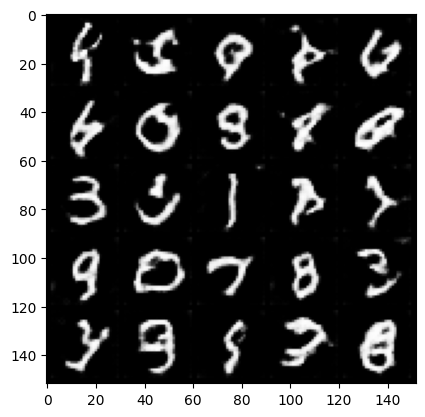

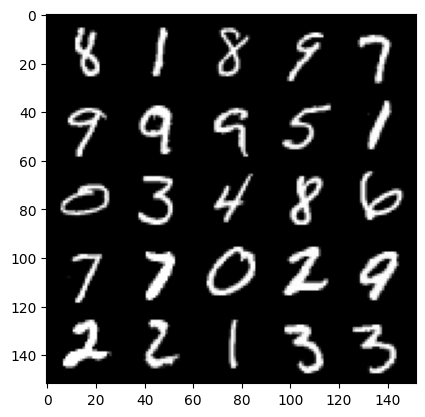

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17, step 8000: Generator loss: 1.582507887601852, discriminator loss: 0.4757511164247987


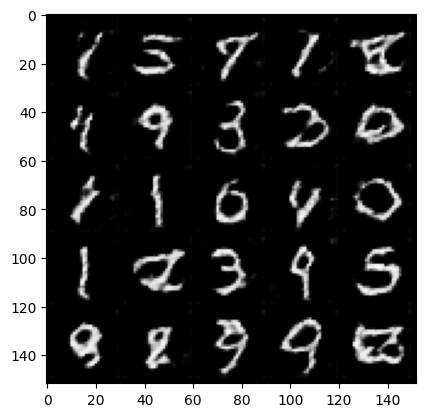

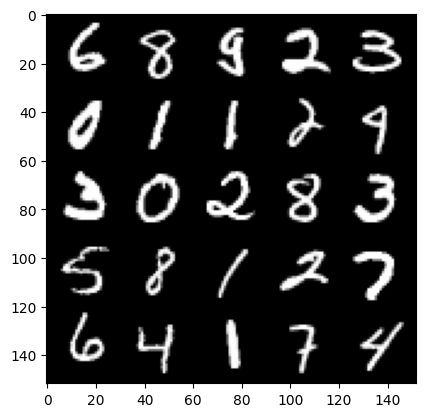

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18, step 8500: Generator loss: 1.5331911290884028, discriminator loss: 0.4772913238704202


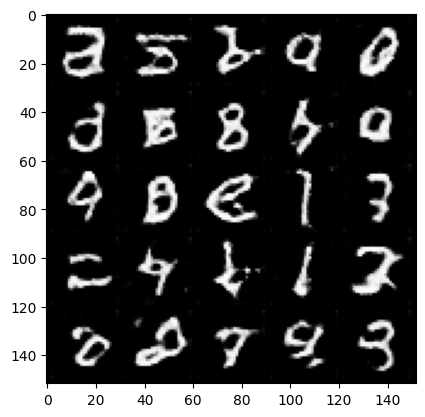

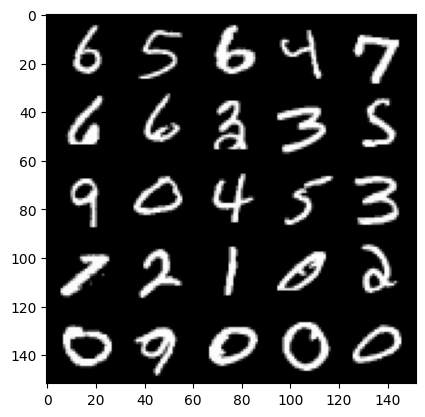

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19, step 9000: Generator loss: 1.501707578301429, discriminator loss: 0.5018426900506018


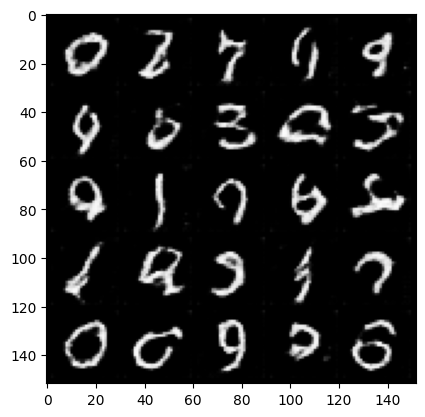

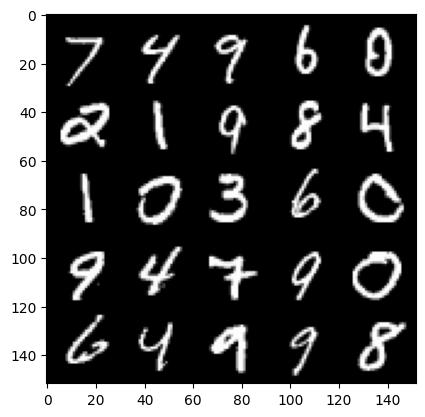

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20, step 9500: Generator loss: 1.4211935390234014, discriminator loss: 0.5282628553509717


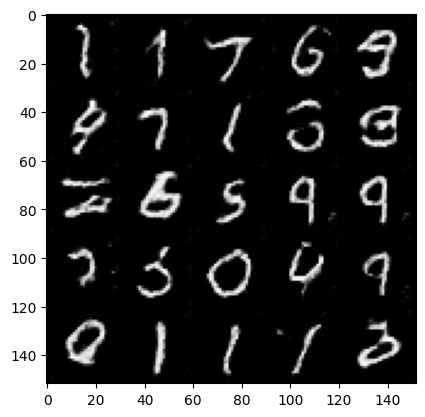

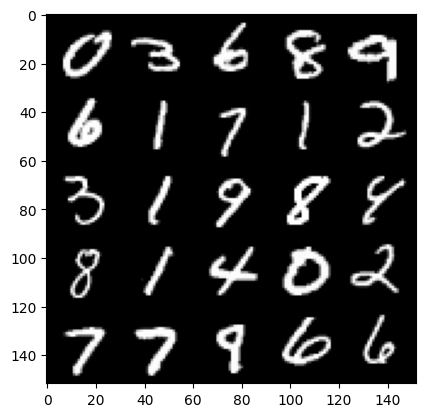

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21, step 10000: Generator loss: 1.4032519437074664, discriminator loss: 0.5257729396820067


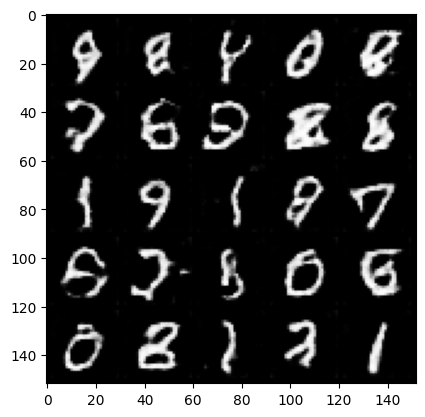

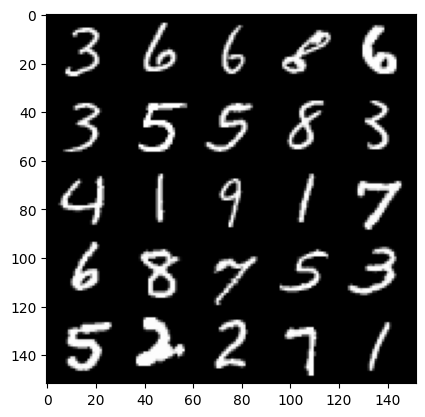

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22, step 10500: Generator loss: 1.3463041548728933, discriminator loss: 0.552740005910397


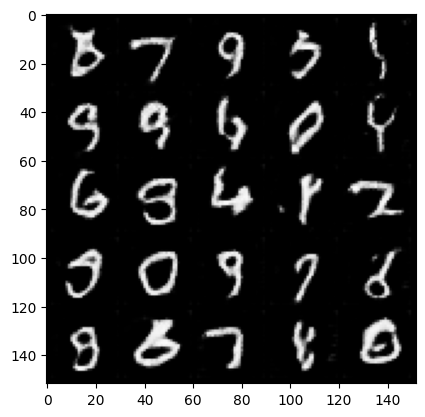

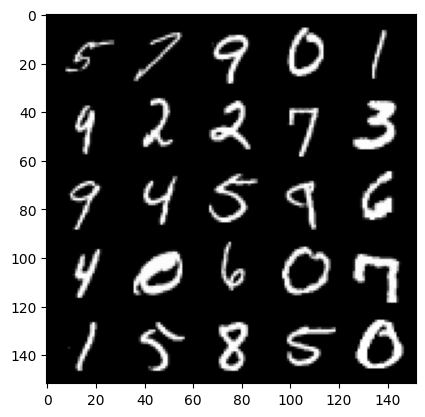

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23, step 11000: Generator loss: 1.2761353225708005, discriminator loss: 0.548804103314877


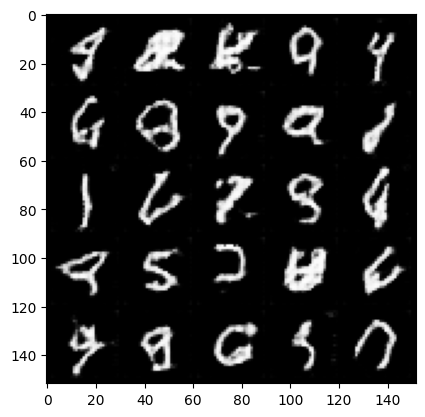

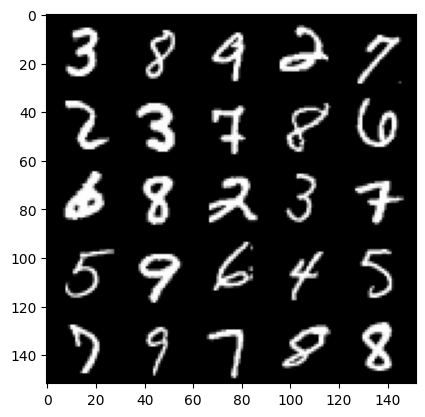

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24, step 11500: Generator loss: 1.2627070248126988, discriminator loss: 0.569742501437664


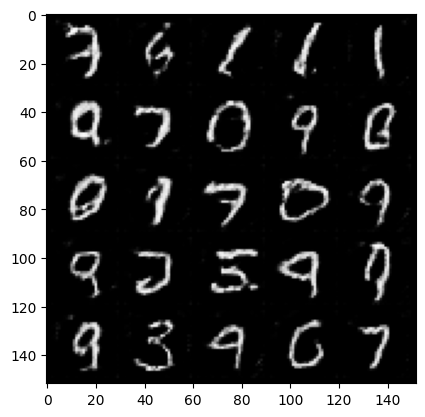

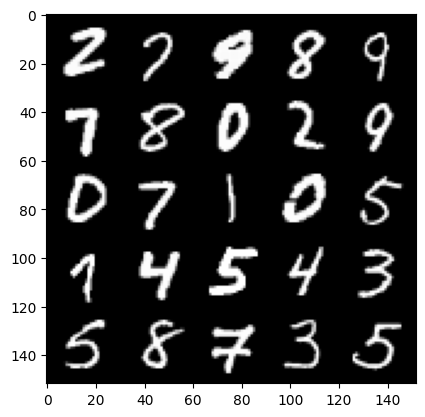

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25, step 12000: Generator loss: 1.2982489106655117, discriminator loss: 0.5608131564855576


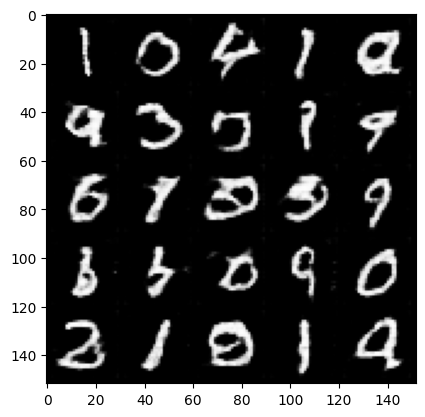

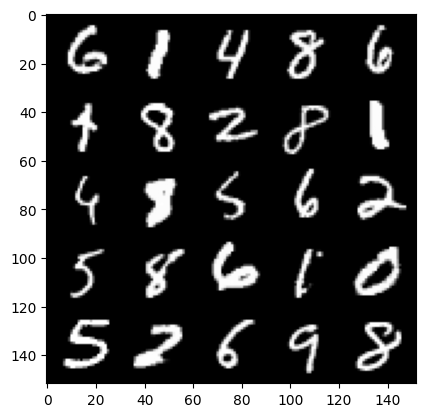

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26, step 12500: Generator loss: 1.2044321186542513, discriminator loss: 0.557865792453289


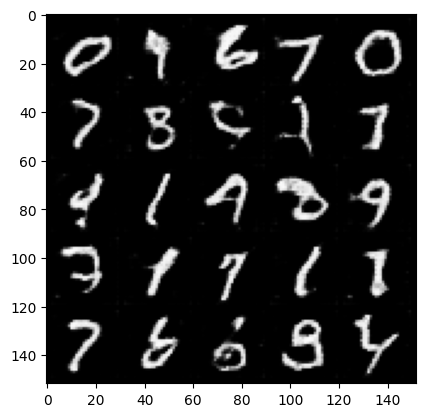

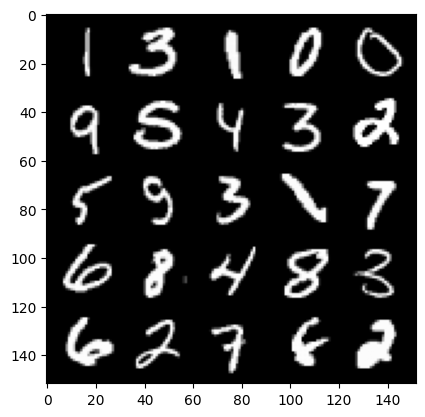

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27, step 13000: Generator loss: 1.1656112197637563, discriminator loss: 0.5917504940629008


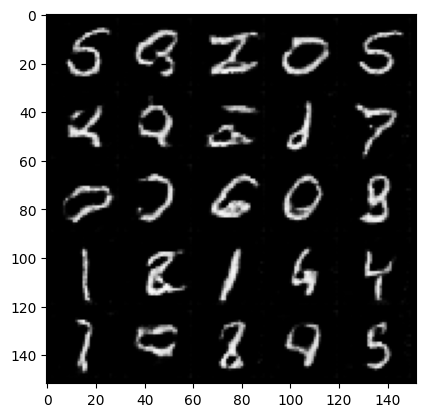

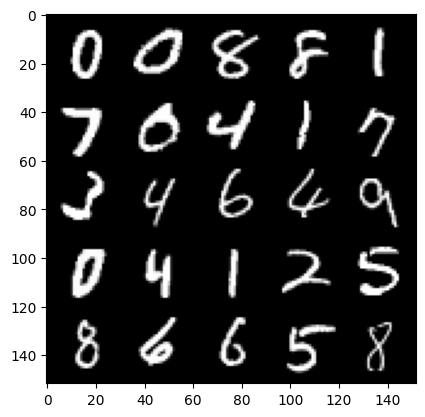

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28, step 13500: Generator loss: 1.1563941907882684, discriminator loss: 0.579328815877438


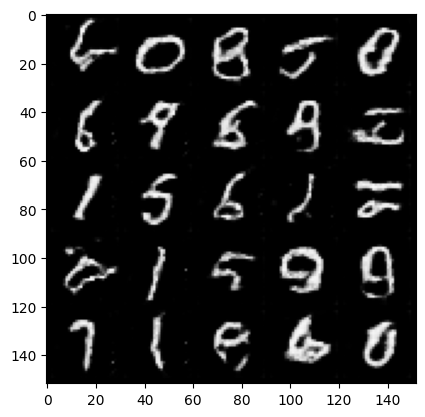

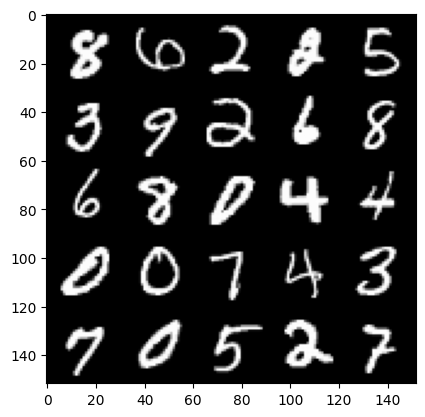

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29, step 14000: Generator loss: 1.1562237718105324, discriminator loss: 0.6263367990255353


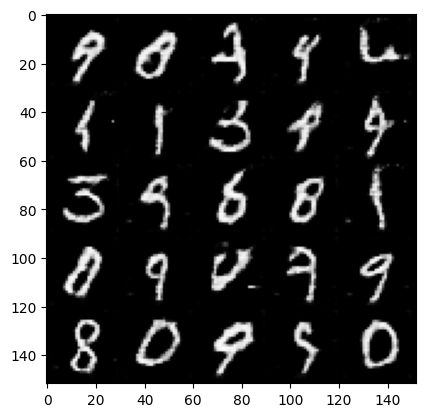

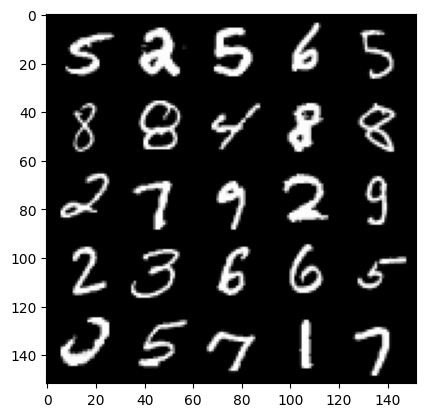

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30, step 14500: Generator loss: 1.0854605811834326, discriminator loss: 0.6099645369648935


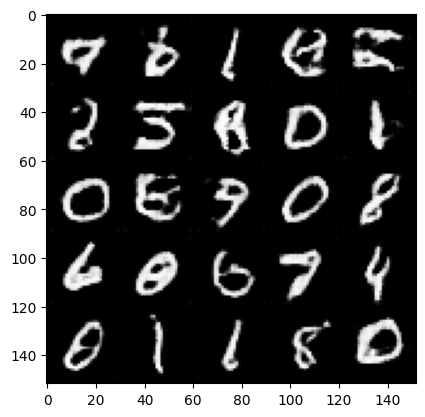

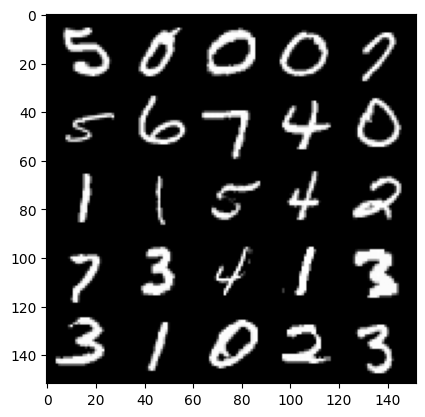

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31, step 15000: Generator loss: 1.1075380247831352, discriminator loss: 0.6176942744851107


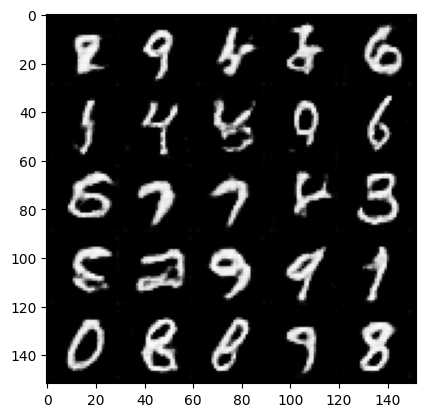

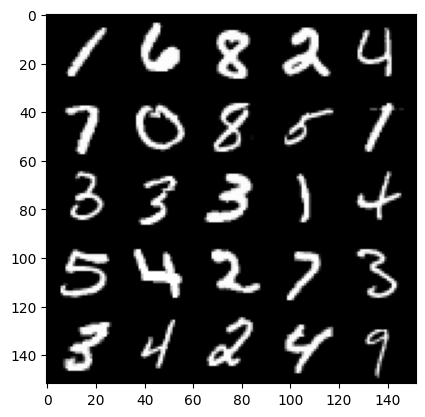

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33, step 15500: Generator loss: 1.0985766432285304, discriminator loss: 0.6186513943076143


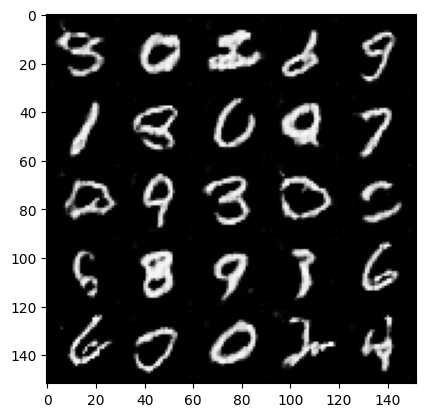

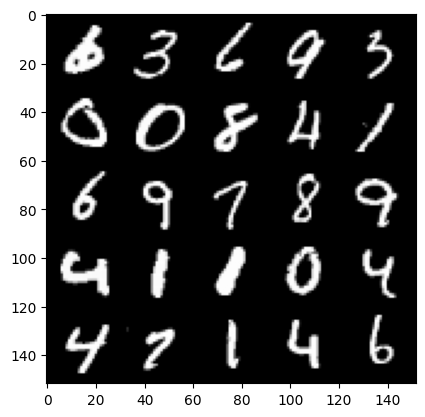

In [ ]:
# OPTIONAL PART

n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False
error = False
for epoch in range(n_epochs):

    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # We donot Flatten the Image here
        real = real.to(device)

        ### Update discriminator ###
        """
        The generator creates fake images from random noise.
        The discriminator tries to distinguish between real images (from the dataset) and fake images (from the generator).
        The discriminator is trained by computing the loss based on how well it can classify real and fake images (using binary cross-entropy loss).
        The discriminator’s loss is the average of its performance on real and fake images.
        """
        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()
        # Generating Fake Noise
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        #  Generating Fake Images
        fake = gen(fake_noise)
        # Discriminating Fake Images
        disc_fake_pred = disc(fake.detach())
        # Calculating Fake Image Loss
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        # Discriminating Real Images
        disc_real_pred = disc(real)
        # Calculating Real Image
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        # Calculating Total Discriminator Loss
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

         # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()


        ### Update generator ###
        """
        The generator receives random noise as input and generates fake images.
        The discriminator evaluates these fake images and the generator aims to trick the discriminator into classifying them as real.
        The generator's loss is computed based on how well it managed to fool the discriminator.
        Backpropagation is performed to compute gradients and update the generator's weights using the optimizer.
        """

        # Zeroing the Gradients for the Generator
        gen_opt.zero_grad()
        # Generating Fake Noise
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        # Generating Fake Images
        fake_2 = gen(fake_noise_2)
        # Passing Fake Images Through the Discriminator
        disc_fake_pred = disc(fake_2)
        # Calculating Generator Loss
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        # Backpropagating the Generator Loss
        gen_loss.backward()
        # Updating the Generator's Weights
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
